In [2]:
# TODO:
# 1. Update bert
# 2. add crf on the top
# +3. calculate probability of a sequence
# 4. Try CRF with features from ACL paper
# 5. Try other dataset (CONLL-2003, OntonNotes 5.0)
# 6. Try poked BERT
# 7. Draw plots for CAD, HYP, DIABETES
# 8. Try document-level annotations
# 9. Create Bi-LSTM CRF baseline using Flair
# 10. Разобраться с тем как оценивали участники результаты на проверочном корпусе 

# 11. Take small amount of unannotated data, build dictionary and try to outperform the dictionary baseline
# 12. Show that language models are super cool for active learning since you can use just a shallow architecture for training (faster)
# 13. Just show that bert kills old baselines.
# 14. Unlexicalized BERT for active learning
# 15. Propose an self-attention network for tagging and show it is better than LSTM
# 16. New variants of ranking procedure. Most uncertain among those that get positive labels. Most uncertain among tokens that have positive labels.

# Calculate % of data by using number of tokens.

In [ ]:
!pip install git+https://github.com/IINemo/libact.git@seq

In [ ]:
#!pip install -e ./packages/libact/

!pip install git+https://github.com/IINemo/active_learning_toolbox.git@seq

# Initialization

In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import sys

#sys.path += ['./active_learning_toolbox/']

In [2]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()

for i in range(n_gpu):
    print(torch.cuda.get_device_name(i))

Tesla V100-DGXS-16GB


In [3]:
import logging
logger = logging.getLogger('active_learning')

formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')

fhandler = logging.FileHandler(filename='../workdir/i2b2_active_learning.log', mode='a')
fhandler.setFormatter(formatter)
logger.addHandler(fhandler)

handler = logging.StreamHandler(sys.stdout)
handler.setFormatter(formatter)
logger.addHandler(handler)

logger.setLevel(logging.DEBUG)

In [4]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm

# Global parameters

In [5]:
CACHE_DIR = '../workdir/models/0.4.0'

MAX_LEN = 150
BATCH_SIZE = 32
random_state = 2019

# Load dataset

In [6]:
from i2b2_utils import drop_noise_samples, tokenize_and_generate_labels, split_train_test_by_document, create_tensors, train

import torch
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertForTokenClassification, BertAdam

from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

In [7]:
dataset_path = '../workdir/all_attributes.json'
dataset = pd.read_json(dataset_path)
print(dataset.shape)
dataset.head()

(46635, 5)


,HYPERTENSION,CAD,DIABETES,texts,doc_ids
0,[],[],[],Record date: 2154-07-21\n\n\n\tCARDIOLOGY\n\t\...,0
1,[],[],[],D.,0
10,"[[24, 36]]",[],[],She has well-controlled hypertension on stable...,0
100,[],[],[],a.,1
1000,[],[],[],"SOCIAL HISTORY, FAMILY HISTORY, AND REVIEW OF ...",18


In [8]:
#attr_name = 'HYPERTENSION'
#attr_name = 'CAD'
attr_name = 'DIABETES'

selected_dataset = drop_noise_samples(dataset, attr_name)
selected_dataset.shape

(14183, 5)

In [9]:
train_selected_dataset, test_selected_dataset = split_train_test_by_document(selected_dataset, test_ratio=0.2)

# Prepare model and preprocessing

In [10]:
from isanlp.en.processor_tokenizer_nltk_en import ProcessorTokenizerNltkEn

word_tokenizer = ProcessorTokenizerNltkEn()
bpe_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', cache_dir=CACHE_DIR, do_lower_case=False)
train_sents, train_labels = tokenize_and_generate_labels(word_tokenizer, bpe_tokenizer, train_selected_dataset, attr_name, MAX_LEN)
test_sents, test_labels = tokenize_and_generate_labels(word_tokenizer, bpe_tokenizer, test_selected_dataset, attr_name, MAX_LEN)

2019-06-18 16:10:45,334 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3.amazonaws.com:443
2019-06-18 16:10:46,553 - urllib3.connectionpool - DEBUG - https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-base-cased-vocab.txt HTTP/1.1" 200 0
2019-06-18 16:10:46,559 - pytorch_pretrained_bert.tokenization - INFO - loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt from cache at ../workdir/models/0.4.0/5e8a2b4893d13790ed4150ca1906be5f7a03d6c4ddf62296c383f6db42814db2.e13dbb970cb325137104fb2e5f36fe865f27746c6b526f6352861b1980eb80b1


In [11]:
tags_vals = ['B', 'I', 'O', 'X', '[CLS]', '[SEP]']
tag2idx = {t : i for i, t in enumerate(tags_vals)}

In [12]:
train_input_ids, train_tags, train_attention_masks = create_tensors(bpe_tokenizer, tag2idx, 
                                                                    train_sents, train_labels, MAX_LEN)
test_input_ids, test_tags, test_attention_masks = create_tensors(bpe_tokenizer, tag2idx, 
                                                                 test_sents, test_labels, MAX_LEN)

In [8]:
def create_model_optimizer(tag2idx):
    model = BertForTokenClassification.from_pretrained('bert-base-cased', 
                                                       cache_dir=CACHE_DIR, 
                                                       num_labels=len(tag2idx))
    model.cuda()
    
    lr_head = 5e-4
    lr_body = 5e-5
    weight_decay = 0.01

    FULL_FINETUNING = True
    if FULL_FINETUNING:
        param_optimizer = list(model.bert.named_parameters())
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer 
                        if not any(nd in n for nd in no_decay)],
             'weight_decay': weight_decay},
            {'params': [p for n, p in param_optimizer 
                        if any(nd in n for nd in no_decay)],
             'weight_decay': 0.0},
            {'params' : [p for n, p in model.classifier.named_parameters()
                         if not any(nd in n for nd in no_decay)],
             'lr' : lr_head,
             'weight_decay': weight_decay},
            {'params' : [p for n, p in model.classifier.named_parameters()
                        if any(nd in n for nd in no_decay)],
             'lr' : lr_head,
             'weight_decay' : 0.0
            }
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters()) 
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]


    optimizer = BertAdam(optimizer_grouped_parameters, lr=lr_body)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    return model, optimizer, lr_scheduler

# Training

In [ ]:
model, optimizer, lr_scheduler = create_model_optimizer()

t_tr_inputs = torch.tensor(train_input_ids)
t_tr_tags = torch.tensor(train_tags)
t_tr_masks = torch.tensor(train_attention_masks)

t_val_inputs = torch.tensor(test_input_ids)
t_val_tags = torch.tensor(test_tags)
t_val_masks = torch.tensor(test_attention_masks)

train_data = TensorDataset(t_tr_inputs, t_tr_masks, t_tr_tags)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=bs)

valid_data = TensorDataset(t_val_inputs, t_val_masks, t_val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=bs, shuffle=False)

train(model, optimizer, lr_scheduler, train_dataloader, valid_dataloader, 
      epochs=10, device=device, tags_vals=tags_vals)

In [ ]:
model.eval()
predictions = []
true_labels = []
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
for batch in valid_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        tmp_eval_loss = model(b_input_ids, token_type_ids=None,
                              attention_mask=b_input_mask, labels=b_labels)
        logits = model(b_input_ids, token_type_ids=None,
                       attention_mask=b_input_mask)
        
    logits = logits.detach().cpu().numpy()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    label_ids = b_labels.to('cpu').numpy()
    true_labels.append(label_ids)
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)

    eval_loss += tmp_eval_loss.mean().item()
    eval_accuracy += tmp_eval_accuracy

    nb_eval_examples += b_input_ids.size(0)
    nb_eval_steps += 1

pred_tags = [[tags_vals[p_i] for p_i in p] for p in predictions]
valid_tags = [[tags_vals[l_ii] for l_ii in l_i] for l in true_labels for l_i in l ]
print("Validation loss: {}".format(eval_loss/nb_eval_steps))
print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))
print("Validation F1-Score: {}".format(f1_score(pred_tags, valid_tags)))

# Active learning

In [9]:
from actleto import ActiveLearner, make_libact_strategy_ctor
from libact.query_strategies import UncertaintySampling, RandomSampling
from active_learning_seq import LibActNN, f1_score_wrapper, RandomSamplingWithRetraining


def initialize_seeds(train_input_ids, train_tags, tags_vals, n_seeds_per_class=10):
    indexes = np.array(range(train_tags.shape[0]))
    known_indexes = []
    for label in range(len(tags_vals)):
        selected_indices = indexes[(train_tags == label).astype('float').sum(axis=1) != 0]
        known_indexes += list(np.random.choice(selected_indices, size=n_seeds_per_class))

    known_indexes = list(set(known_indexes))
    print(len(known_indexes))
    tags_seed = [None for _ in range(train_tags.shape[0])]

    for i in known_indexes:
        tags_seed[i] = train_tags[i]

    Y_seed = tags_seed
    X_train = train_input_ids
    
    return X_train, Y_seed
    

def create_active_learner(X_train, Y_seed, 
                          X_test, y_test, 
                          tags_vals,
                          libact_model, 
                          ranking_strategy,
                          rnd_steps=0):
    max_samples_number = 20
    random_state = 42

    active_learn_alg_ctor = make_libact_strategy_ctor(lambda tr_ds: ranking_strategy(tr_ds, libact_model), 
                                                      max_samples_number=max_samples_number)
    
    def _f1_score(a,b):
        return f1_score_wrapper(tags_vals, a,b)

    # Creating ActiveLearning object that implements AL logic.
    active_learner = ActiveLearner(active_learn_alg_ctor = active_learn_alg_ctor,
                                   y_dtype = 'int',
                                   X_full_dataset = X_train, 
                                   y_full_dataset = Y_seed,
                                   X_test_dataset = X_test,
                                   y_test_dataset = y_test,
                                   model_evaluate=libact_model,
                                   eval_metrics=[_f1_score],
                                   rnd_start_steps=rnd_steps, 
                                   rnd_start_samples=max_samples_number)
    
    return active_learner


def emulate_active_learning(train_tags, active_learner, 
                            max_iterations=12, n_annotations_per_iter=20, 
                           fit_model=False):
    logger.info('Start emulating active learning.')
    active_learner.start()
    logger.info('Evaluation:', active_learner.evaluate(fit_model=False))

    statistics = []
    for i in range(max_iterations):
        logger.info('Active learning iteration: #{}'.format(i))
        samples_to_annotate = active_learner.choose_samples_for_annotation()
        active_learner.make_iteration(samples_to_annotate, train_tags[samples_to_annotate])
        perf = active_learner.evaluate(fit_model=fit_model)
        statistics.append(perf)
        logger.info('Performance:', perf)
    
    return statistics

## Perform single emulation of AL

In [15]:
model, optimizer, lr_scheduler = create_model_optimizer(tag2idx)
libact_model = LibActNN(model, optimizer, lr_scheduler, device=device, batch_size=BATCH_SIZE)

2019-06-18 16:10:55,560 - urllib3.connectionpool - DEBUG - Starting new HTTPS connection (1): s3.amazonaws.com:443
2019-06-18 16:10:58,010 - urllib3.connectionpool - DEBUG - https://s3.amazonaws.com:443 "HEAD /models.huggingface.co/bert/bert-base-cased.tar.gz HTTP/1.1" 200 0
2019-06-18 16:10:58,016 - pytorch_pretrained_bert.modeling - INFO - loading archive file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased.tar.gz from cache at ../workdir/models/0.4.0/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c
2019-06-18 16:10:58,020 - pytorch_pretrained_bert.modeling - INFO - extracting archive file ../workdir/models/0.4.0/a803ce83ca27fecf74c355673c434e51c265fb8a3e0e57ac62a80e38ba98d384.681017f415dfb33ec8d0e04fe51a619f3f01532ecea04edbfd48c5d160550d9c to temp dir /tmp/tmp0a1a46hf
2019-06-18 16:11:05,066 - pytorch_pretrained_bert.modeling - INFO - Model config {
  "attention_probs_dropout_prob": 

In [16]:
np.random.seed(42)

In [17]:
X_train, Y_seed = initialize_seeds(train_input_ids, train_tags, tags_vals)

60


In [20]:
ranking_strategy = lambda trn_ds, libact_model: UncertaintySampling(trn_ds, model=libact_model, method='lc')
#ranking_strategy = lambda trn_ds, libact_model: RandomSamplingWithRetraining(trn_ds, libact_model)

active_learner = create_active_learner(X_train, Y_seed, test_input_ids, test_tags, tags_vals, 
                                       libact_model=libact_model, ranking_strategy=ranking_strategy, rnd_steps=1)

NameError: name 'X_train' is not defined

In [19]:
statistics = emulate_active_learning(active_learner)

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Start


Epoch:  33%|███▎      | 1/3 [00:00<00:01,  1.32it/s]

Train loss: 1.218969076871872


Epoch:  67%|██████▋   | 2/3 [00:01<00:00,  1.35it/s]

Train loss: 0.36274728924036026


Epoch: 100%|██████████| 3/3 [00:02<00:00,  1.37it/s]

Train loss: 0.12889960780739784


KeyboardInterrupt: 

In [96]:
import json

statistics_path = '../workdir/statistics_us.json'
#statistics_path = '../workdir/statistics_random.json'

with open(statistics_path, 'w') as f:
    json.dump(statistics, f)

In [97]:
with open('../workdir/statistics_us.json', 'r') as f:
    statistics_us = json.load(f)
    
with open('../workdir/statistics_random.json', 'r') as f:
    statistics_random = json.load(f)

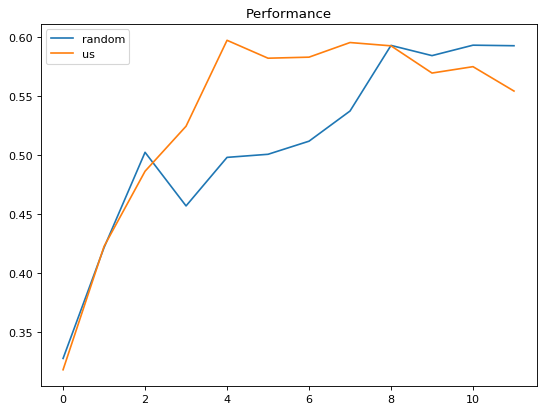

In [98]:
import matplotlib.pyplot as plt
%matplotlib inline 

from matplotlib.pyplot import figure
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt1, = plt.plot(list(range(len(statistics))), [e['_f1_score'] for e in statistics_random], label='random')
plt2, = plt.plot(list(range(len(statistics_us))), [e['_f1_score'] for e in statistics_us], label='us')
plt.legend(handles=[plt1, plt2])
plt.title('Performance')
plt.show()

## Multiple AL evaluations

In [10]:
def perform_several_al_passes(train_input_ids, train_tags, 
                              test_input_ids, test_tags, 
                              tags_vals, tag2index, 
                              ranking_strategy, fit_model, 
                              n_passes):
    stats = []
    for i in range(n_passes):
        logger.info('=============== Pass: {} ============='.format(i))
        
        np.random.seed(42 + i*3)
        
        model, optimizer, lr_scheduler = create_model_optimizer(tag2index)
        libact_model = LibActNN(model, optimizer, lr_scheduler, device=device, batch_size=BATCH_SIZE)

        X_train, Y_seed = initialize_seeds(train_input_ids, train_tags, tags_vals)
        active_learner = create_active_learner(X_train, Y_seed, test_input_ids, test_tags, 
                                               tags_vals, libact_model, ranking_strategy=ranking_strategy)
        
        statistics = emulate_active_learning(train_tags, active_learner, fit_model=fit_model)
        stats.append(statistics)
    
    return stats

In [39]:
#ranking_strategy = lambda trn_ds, libact_model: RandomSamplingWithRetraining(trn_ds, model=libact_model)
ranking_strategy = lambda trn_ds, libact_model: UncertaintySampling(trn_ds, model=libact_model, method='lc')
stats = perform_several_al_passes(ranking_strategy)

TypeError: perform_several_al_passes() missing 6 required positional arguments: 'train_tags', 'test_input_ids', 'test_tags', 'tags_vals', 'tag2index', and 'ranking_strategy'

In [102]:
np_stats = np.array([[e['_f1_score'] for e in series] for series in stats ])

In [103]:
np.save('../workdir/us_stats1.npy', np_stats)

In [46]:
np.save('../workdir/random_stats.npy', np_stats)

In [11]:
us_stats = np.load('../workdir/experiments/hypertension_us.npy')
us_stats = np.array([[e['_f1_score'] for e in series] for series in us_stats ])
random_stats = np.load('../workdir/experiments/hypertension_random.npy')

2019-06-20 17:16:56,245 - matplotlib - DEBUG - CACHEDIR=/root/.cache/matplotlib
2019-06-20 17:16:56,247 - matplotlib.font_manager - DEBUG - font search path ['/root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf', '/root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/afm', '/root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/pdfcorefonts']
2019-06-20 17:16:56,278 - matplotlib.font_manager - DEBUG - createFontDict: /root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf
2019-06-20 17:16:56,280 - matplotlib.font_manager - DEBUG - createFontDict: /root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf
2019-06-20 17:16:56,281 - matplotlib.font_manager - DEBUG - createFontDict: /root/.pyenv/versions/3.6.7/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/cmr10.ttf
2019-06-20 17:16:56,282 - matplot

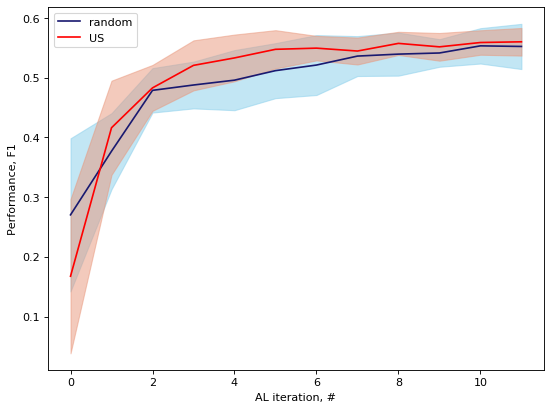

2019-06-20 17:16:57,547 - matplotlib.pyplot - DEBUG - Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [14]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline 


def generate_plot(np_stats, color_bg, color_line, label):
    disp = np_stats.std(axis=0)
    means = np_stats.mean(axis=0)

    x = list(range(means.shape[0]))

    plt.fill_between(x, means - disp, means + disp, color=color_bg, alpha=0.5)
    return plt.plot(x, means, color=color_line, label=label)

    
figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

plt1, = generate_plot(random_stats, color_bg='skyblue', color_line='midnightblue', label='random')
plt2, = generate_plot(us_stats, color_bg='darksalmon', color_line='red', label='US')

plt.legend(handles=[plt1, plt2])
plt.ylabel('Performance, F1')
plt.xlabel('AL iteration, #')
plt.show()

In [21]:
plt.draw()
plt.savefig('../data/hypertension.png')

In [11]:
def run_experiment_al(dataset, 
                      attr_name, 
                      word_tokenizer, 
                      bpe_tokenizer,
                      output_file_path,
                      n_passes=10):
    logger.info('Preparing data...')
    
    selected_dataset = drop_noise_samples(dataset, attr_name)
    train_selected_dataset, test_selected_dataset = split_train_test_by_document(selected_dataset, test_ratio=0.2)
    train_sents, train_labels = tokenize_and_generate_labels(word_tokenizer, bpe_tokenizer, 
                                                             train_selected_dataset, attr_name, MAX_LEN)
    test_sents, test_labels = tokenize_and_generate_labels(word_tokenizer, bpe_tokenizer, 
                                                           test_selected_dataset, attr_name, MAX_LEN)
    
    tags_vals = ['B', 'I', 'O', 'X', '[CLS]', '[SEP]']
    tag2idx = {t : i for i, t in enumerate(tags_vals)}
    
    train_input_ids, train_tags, train_attention_masks = create_tensors(bpe_tokenizer, tag2idx, 
                                                                        train_sents, train_labels, MAX_LEN)
    test_input_ids, test_tags, test_attention_masks = create_tensors(bpe_tokenizer, tag2idx, 
                                                                     test_sents, test_labels, MAX_LEN)
    
    logger.info('Done.')
    
    logger.info('Initializing model...')
    
    model, optimizer, lr_scheduler = create_model_optimizer(tag2idx)
    
    logger.info('Done.')
    
    logger.info('Preparing active learning...')
    
    logger.info('Done.')
    
    logger.info('=======================Active learning with uncertainty sampling ======================')
    
    ranking_strategy = lambda trn_ds, _libact_model: UncertaintySampling(trn_ds, model=_libact_model, method='lc')
    stats = perform_several_al_passes(train_input_ids, train_tags, test_input_ids, 
                                      test_tags, tags_vals, tag2idx, 
                                      ranking_strategy=ranking_strategy, fit_model=False, 
                                      n_passes=n_passes)
    np.save(os.path.join(output_file_path, '{}_us.npy'.format(attr_name.lower())), stats)
    
    logger.info('Done with uncertainty sampling.')
    
    logger.info('=======================Active learning with random sampling ============================')
    
    ranking_strategy = lambda trn_ds, _libact_model: RandomSamplingWithRetraining(trn_ds, model=_libact_model, method='lc')
    stats = perform_several_al_passes(train_input_ids, train_tags, 
                                      test_input_ids, test_tags, 
                                      tags_vals, tag2idx, 
                                      ranking_strategy=ranking_strategy, 
                                      fit_model=False,
                                      n_passes=n_passes)
    stats = np.array([[e['_f1_score'] for e in series] for series in stats ])
    np.save(os.path.join(output_file_path, '{}_random.npy'.format(attr_name.lower())), stats)
    
    logger.info('Done.')

In [12]:
from isanlp.en.processor_tokenizer_nltk_en import ProcessorTokenizerNltkEn

word_tokenizer = ProcessorTokenizerNltkEn()
bpe_tokenizer = BertTokenizer.from_pretrained('bert-base-cased', cache_dir=CACHE_DIR, do_lower_case=False)
run_experiment_al(dataset, 'DIABETES', word_tokenizer, bpe_tokenizer, '../workdir/experiments/')

2019-06-21 09:09:36,409 - active_learning - INFO - Preparing data...
2019-06-21 09:09:46,488 - active_learning - INFO - Done.
2019-06-21 09:09:46,489 - active_learning - INFO - Initializing model...


t_total value of -1 results in schedule not being applied


2019-06-21 09:10:04,343 - active_learning - INFO - Done.
2019-06-21 09:10:04,344 - active_learning - INFO - Preparing active learning...
2019-06-21 09:10:04,345 - active_learning - INFO - Done.
2019-06-21 09:10:04,346 - active_learning - INFO - =======================Active learning with uncertainty sampling ======================


TypeError: perform_several_al_passes() missing 1 required positional argument: 'n_passes'